In [1]:
!pip3 install transformers
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip3 install gputil
!pip3 install psutil
!pip3 install humanize

In [2]:
# download spacy models for english and german

!spacy download en_core_web_md
!spacy link en_core_web_md en300

# !spacy download de_core_news_md
# !spacy link de_core_news_md de300

!wget -c https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')

✘ Link 'en300' already exists
To overwrite an existing link, use the --force flag

--2020-02-28 14:13:18--  https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘chinese_stop_words.txt’

chinese_stop_words.     [ <=>                ] 417.17K  --.-KB/s    in 0.02s   

2020-02-28 14:13:19 (20.7 MB/s) - ‘chinese_stop_words.txt’ saved [429644]



In [3]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, sampler
import spacy
import torchtext

from nltk import download
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
import string
import jieba
import gensim

import io
import os
from os.path import exists
import matplotlib.pyplot as plt

import time

download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle

# get embeddings
glove300 = torchtext.vocab.GloVe(name='6B', dim=300, cache='/content/gdrive/My Drive/Colab Notebooks')
pickle.dump(glove300, open('/content/gdrive/My Drive/Colab Notebooks/glove300.pkl', 'wb'))
glove3000 = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/glove300.pkl', 'rb'))

In [0]:
# download and unzip the data
language = 'enzh' #'ende' or 'enzh'

file_name = language + '_data.zip'

if language == 'enzh' and not exists(file_name):
    !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
    !unzip enzh_data.zip

elif language == 'ende' and not exists(file_name):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip
 

In [0]:
# get stop words
stop_words_en = set(stopwords.words('english'))
stop_words_zh = [line.rstrip() for line in open(os.path.expanduser('./chinese_stop_words.txt'), "r", encoding="utf-8")]
stop_words_de = set(stopwords.words('german'))

In [0]:
# preprocessing...
 
def preprocessing(sentence, lang, nlp, remove_stop_word=True):
    """
    Preprocesses the sentence by lowercasing, lemmatizing (if not chinese),
    removing stopwords and tokenizing.

    :param sentence: str object. Sentence to preprocess
    :param lang: language of the sentnece. Options: 'zh', 'en', 'de'
    :param nlp: spacy nlp object if language is 'en' or 'de'. gensim.model if
                language='zh'
    :remove_stop_word: if True, remove stopwords

    :return: list of tokens of the sentence
    """
    if lang == 'zh':
        line = jieba.lcut(sentence, cut_all=True)
        if remove_stop_word:
            line = [word for word in line if word not in stop_words_zh]
        line = [e for e in line if e.isalnum()] # True if all characters in the string are alphanumeric (no whitespace etc.)
    elif lang == 'en':
        text = sentence.lower()
        line = [token.lemma_ for token in nlp.tokenizer(text)]
        if remove_stop_word:
            line = [word for word in line if word not in stop_words_en]
    elif lang == 'de':
        text = sentence.lower()
        line = [token.lemma_ for token in nlp.tokenizer(text)]
        if remove_stop_word:
            line = [word for word in line if word not in stop_words_de]
    return line

In [0]:
def get_embeddings(data, lang, max_len_lang, nlp, embedding_dim=300,
                   remove_stop_word=True):
    """
    Converts all sentences in the data into its word embeddings. Combines
    preprocessing() and get_sentence_vector()

    :param data: ndarray of sentences in the data
    :param lang: language of the data
    :param max_len_lang: maximum length of each sentence
    :param nlp: spacy nlp object if language is 'en' or 'de'. gensim.model if
                language='zh'
    :param embedding_dim: embedding dimension of each token
    :param remove_stop_word: if True, remove stop words

    :return: sentence_vectors of shape (n_sentence, max_len_lang, embedding_dim)
    """
    sentence_vectors = np.zeros(shape=(len(data), max_len_lang, embedding_dim))

    for idx, sentence in enumerate(data):
        sentence_tokens = preprocessing(sentence, lang, nlp, remove_stop_word)
        sentence_vectors[idx] = get_sentence_vector(sentence_tokens, lang, max_len_lang, nlp, embedding_dim)

    return sentence_vectors # -> (n_sentence, max_len_lang, embedding_dim)

In [0]:
def get_sentence_vector(sentence_tokens, lang, max_len_lang, nlp,
                        embedding_dim=300):
    """
    Converts each token of the sentence to its word embedding (vector). If the
    sentence is longer than max_len_lang, it will be cut. If it's shorter, it'll
    be zero padded.

    :param sentence_tokens: list of tokens in the sentence
    :param lang: language of the sentence
    :param max_len_lang: maximum length of the sentence
    :param nlp: spacy nlp object if language is 'en' or 'de'. gensim.model if
                language='zh'
    :param embedding_dim: embedding dimension of tokens

    :return: nd.array of word embeddings of the sentence with shape
             (max_len_lang, embedding_dim)
    """
    vectors = np.ones(shape=(max_len_lang, embedding_dim))

    if lang == 'en' and embedding_dim == 300:
        for idx, w in enumerate(sentence_tokens):
            if idx >= max_len_lang: # Cut the sentence short if it's too long
                break
            try:
                vectors[idx] = glove300.vectors[glove300.stoi[w]].numpy()
            except: # all zero vector for unknown words (consistent with spacy)
                vectors[idx] = np.zeros(embedding_dim)
    elif lang == 'zh' and embedding_dim == 300:
        for idx, w in enumerate(sentence_tokens):
            if idx >= max_len_lang:
                break
            try:
                vectors[idx] = nlp.wv[w]
            except: # all zero vector for unknown words (consistent with spacy)
                vectors[idx] = np.zeros(embedding_dim)
    else:
        raise Exception('other embedding dim not implemented yet...use 300')

    return vectors # -> (max_len_lang, embedding_dim)

In [0]:
def get_embedding_dataloaders(language, batch_size, max_len=100,
                               embedding_dim=300, remove_stop_word=True):
    """
    Get dataloaders with word embeddings where each batch will have a shape
    (batch_size, max_len, embedding_dim)

    :param language: translation language model to use. Options: 'ende', 'enzh'
    :param batch_size: batch size of the dataloader
    :param max_len: maximum length of each sentence (please put an even number)
    :param embedding_dim: embedding dimension of each word
    :param remove_stop_word: if True, remove stop words

    :return: three DataLoader objects; loader_train, loader_dev, loader_test
    """
    # Read text files
    train_src, train_mt, train_scores = open_data_files(language, 'train')
    dev_src, dev_mt, dev_scores = open_data_files(language, 'dev')
    test_src, test_mt = open_data_files(language, 'test')

    # Investigate the data by computing the mean and variance of the train and
    # dev set scores
    print('Model language:', language)
    print('variance and mean of train set:', torch.var_mean(train_scores))
    print('variance and mean of dev set:', torch.var_mean(dev_scores))

    lang_src = language[:2]
    lang_mt = language[2:]

    # Get pre-trained Word2Vec models for src and mt languages
    nlp_src = spacy.load('en300')

    if lang_mt == 'zh':
        print('----loading zh model')
        model_zh_300_path = os.path.expanduser('/content/gdrive/My Drive/NLP CW/zh_300.bin')
        nlp_mt = Word2Vec.load(model_zh_300_path)
        print('----finished zh model load')
    elif lang_mt == 'de':
        nlp_mt = spacy.load('de300')

    max_len_lang = max_len // 2

    # Convert src to its embeddings -> (n_sentences, max_len_lang, embedding_dim)
    print('------src start')
    start = time.time()
    train_src_embedding = get_embeddings(train_src, lang_src, max_len_lang, nlp_src, embedding_dim, remove_stop_word)
    dev_src_embedding = get_embeddings(dev_src, lang_src, max_len_lang, nlp_src, embedding_dim, remove_stop_word)
    test_src_embedding = get_embeddings(test_src, lang_src, max_len_lang, nlp_src, embedding_dim, remove_stop_word)
    end = time.time()
    print('------src done', end-start)
    print('------mt start')
    start = time.time()   
    # Convert mt to its embeddings -> (n_sentences, max_len_lang, embedding_dim)
    train_mt_embedding = get_embeddings(train_mt, lang_mt, max_len_lang, nlp_mt, embedding_dim, remove_stop_word)
    dev_mt_embedding = get_embeddings(dev_mt, lang_mt, max_len_lang, nlp_mt, embedding_dim, remove_stop_word)
    test_mt_embedding = get_embeddings(test_mt, lang_mt, max_len_lang, nlp_mt, embedding_dim, remove_stop_word)
    end = time.time()
    print('------mt done', end-start)
    # Concatenate src and mt sentences -> (n_sentences, max_len, embedding_dim)
    train_embedding = torch.Tensor(np.concatenate([train_src_embedding, train_mt_embedding], axis=1))
    dev_embedding = torch.Tensor(np.concatenate([dev_src_embedding, dev_mt_embedding], axis=1))
    test_embedding = torch.Tensor(np.concatenate([test_src_embedding, test_mt_embedding], axis=1))

    print(train_embedding.shape)
    print(train_scores.shape)
    # Create custom datasets
    train_dataset = TensorDataset(train_embedding, train_scores)
    print('train done')
    dev_dataset = TensorDataset(dev_embedding, dev_scores)
    print('dev done')
    test_dataset = TensorDataset(test_embedding)

    # Create DataLoader with batch_size
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    loader_dev = DataLoader(dev_dataset, batch_size=batch_size)
    loader_test = DataLoader(test_dataset, batch_size=batch_size)

    return loader_train, loader_dev, loader_test

In [0]:
def open_data_files(language='enzh', data_type='train'):
    """
    Open data text files and return its mt, src and scores lists. If data_type
    is 'test', scores is omitted.

    :param langauge: language model of the data files. Options: 'enzh', 'ende'
    :param data_type: type of the dataset. Options: 'train', 'dev', 'test'

    :return: np.array, np.array, torch.Tensor (last one omitted
             if data_type='test')
    """
    file_path = os.path.expanduser("./")

    # Read the data files
    mt = pd.read_csv(file_path + '%s.%s.mt' % (data_type, language), header=None, sep='/n', engine='python')[0].to_numpy()
    src = pd.read_csv(file_path + '%s.%s.src' % (data_type, language), header=None, sep='/n', engine='python')[0].to_numpy()

    if data_type == 'test': # test data doesn't have scores
        return src, mt

    scores = torch.from_numpy(np.genfromtxt(file_path + '%s.%s.scores' % (data_type, language), dtype=np.float64, delimiter='/n')).unsqueeze(1)

    return src, mt, scores

In [0]:
import torch
import numpy
import random
import psutil
import humanize
import GPUtil as GPU
import matplotlib.pyplot as plt
import scipy

In [0]:
def fix_seed(seed=234):
  """
  Fix seed for torch and numpy to produce consistent results
  """
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [0]:
def check_GPU_usage():
  """
  Checks the amount of GPU available and used for this Colab runtime
  """
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]

  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
def check_device():
    """
    Checks if we're using GPU

    :return: device
    """
    # Check we're using GPU
    if torch.cuda.is_available():
      torch.backends.cudnn.deterministic = True
      device='cuda:0'
    else:
      device='cpu'
    print('Device is', device)
    return device

In [0]:
# print accuracy
def check_accuracy(loader, model, loss_fn, device):
    loss = 0

    model.eval()  # set model to evaluation mode

    out_list = np.array([])
    y_list = np.array([])

    with torch.no_grad():
        for batch in loader:
            x = tuple(i.to(device=device) for i in batch[:-1])
            y = batch[-1].to(device=device, dtype=torch.float)

            out = model(*x)

            loss += loss_fn(out, y).item()

            out_list = np.concatenate([out_list, out.view(-1).cpu().numpy()])
            y_list = np.concatenate([y_list, y.view(-1).cpu().numpy()])

    pearson_corr = scipy.stats.pearsonr(out_list, y_list)[0]

    print('       - Validation output mean = %.5f, variance = %.5f' % (np.mean(out_list), np.var(out_list)))

    print('       - Validation MSE loss = %.5f' %( loss / len(loader)))
    print("       - Validation Pearson's correlation = %.5f" % (pearson_corr))

In [0]:
# main training loop
def train(model, loader_train, loader_val, optimizer, loss_fn, scheduler=None, epochs=1, device='cuda:0'):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - scheduler: A learning rate scheduler
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    loss_list = []
    print(type(epochs))
    for e in range(epochs):
        print('======= Epoch {:} / {:} ======='.format(e + 1, epochs))
        total_loss = 0

        for c, batch in enumerate(loader_train):

            model.train()  # put model to training mode

            x = tuple(i.to(device=device) for i in batch[:-1])
            # if len(x) != 4:
            #   print('wtf')
            #   raise
            y = batch[-1].to(device=device, dtype=torch.float)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            out = model(*x)

            loss = loss_fn(out, y)

            total_loss += loss.item()
            loss_list.append(loss.item())

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Prevent gradient from exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if c % 100 == 0:
                pearson_r = scipy.stats.pearsonr(out.detach().view(-1).cpu().numpy(), y.detach().view(-1).cpu().numpy())[0]
                print('Iteration {}, loss = {:.4f}, pearson_r = {:.4f}, lr = {:.7f}'.format(c, loss.item(), pearson_r, optimizer.param_groups[0]["lr"]))
                check_accuracy(loader_val, model, loss_fn, device)

                if c != 0:
                    # Plot the train loss
                    plt.close('all')
                    plt.figure()
                    plt.plot(range(len(loss_list)), loss_list)
                    plt.show()
                    #plt.savefig('/loss_graphs/epoch_%.0f_iter_%.0f.pdf' % (epoch + 1, c))

            if scheduler is not None: # Step the scheduler at each iteration
                scheduler.step()

        av_loss = total_loss / len(loader_train)
        print("  Average training loss: {0:.2f}".format(av_loss))

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
# GRU PyTorch class
class GatedRNNForQualityEstimation(nn.Module):
  def __init__(self, embedding_size, rnn_hidden_size, fc_hidden_size, dropout, tanh):
        super().__init__()
        """
        Args:
          embedding_size (int): size of sentance embeddings
          rnn_hidden_size (int): size of hidden state
          fc_hidden_size (int): size of fully-connected layer
          dropout (int): probability of zeroing activations 
          tanh (bool): activation at final layer

        """
        self.tanh = tanh

        self.rnn = nn.GRU(input_size=embedding_size,
                          hidden_size=rnn_hidden_size,
                          batch_first=True, num_layers=2)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=1)
        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        
        
  def forward(self, x):
      """
      Args:
        x: tensor of shape (batch_size, max_length, embedding_size)

      Returns:
        out: tensor of shape (batch_size, 1)

      """
      rnn_out, _ = self.rnn(x)
      pooled = F.max_pool1d(rnn_out.transpose(1, 2), rnn_out.shape[1]).squeeze(2)
      out = self.dropout(pooled)

      if self.tanh:
        out = torch.tanh(self.fc1(out))
      else:
        out = self.fc1(out)
      return out

In [98]:
# model params
import torch.optim as optim
from transformers import AdamW

language = 'enzh'
batch_size = 64
max_len = 60
embedding_dim = 300
remove_stop_word = False

rnn_hidden_size = 720
fc_hidden_size = 640
dropout = 0.1
tanh = False

epochs = 6
lr = 1e-4
eps = 1e-8
step_size = 100
gamma = 0.7

seed = 827

fix_seed(seed)

device = check_device()

Device is cuda:0


In [23]:
# load datab
loader_train, loader_dev, loader_test = get_embedding_dataloaders(language,
                    batch_size, max_len, embedding_dim, remove_stop_word)

Model language: enzh
variance and mean of train set: (tensor(0.8600, dtype=torch.float64), tensor(0.0039, dtype=torch.float64))
variance and mean of dev set: (tensor(0.8276, dtype=torch.float64), tensor(-0.0222, dtype=torch.float64))
----loading zh model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


----finished zh model load
------src start
------src done 4.92410683631897
------mt start


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.579 seconds.
Prefix dict has been built successfully.


------mt done 2.1239373683929443
torch.Size([7000, 60, 300])
torch.Size([7000, 1])
train done
dev done


<class 'int'>
======= Epoch 1 / 6 =======
Iteration 0, loss = 0.5454, pearson_r = 0.2451, lr = 0.0001000
       - Validation output mean = 0.26579, variance = 0.00777
       - Validation MSE loss = 0.36981
       - Validation Pearson's correlation = 0.04907
Iteration 100, loss = 0.3729, pearson_r = 0.0906, lr = 0.0000700
       - Validation output mean = 0.07421, variance = 0.04822
       - Validation MSE loss = 0.34220
       - Validation Pearson's correlation = 0.24857


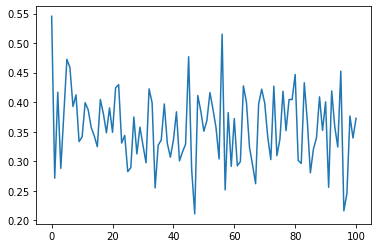

  Average training loss: 0.35
======= Epoch 2 / 6 =======
Iteration 0, loss = 0.2628, pearson_r = 0.3829, lr = 0.0000700
       - Validation output mean = 0.07071, variance = 0.05808
       - Validation MSE loss = 0.34319
       - Validation Pearson's correlation = 0.24134
Iteration 100, loss = 0.4171, pearson_r = 0.2607, lr = 0.0000490
       - Validation output mean = 0.10413, variance = 0.04799
       - Validation MSE loss = 0.33671
       - Validation Pearson's correlation = 0.28274


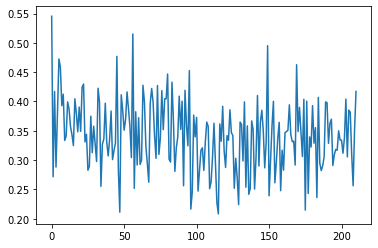

  Average training loss: 0.33
======= Epoch 3 / 6 =======
Iteration 0, loss = 0.2800, pearson_r = 0.4825, lr = 0.0000490
       - Validation output mean = 0.20895, variance = 0.05141
       - Validation MSE loss = 0.34207
       - Validation Pearson's correlation = 0.28382
Iteration 100, loss = 0.2428, pearson_r = 0.5917, lr = 0.0000343
       - Validation output mean = 0.19143, variance = 0.06524
       - Validation MSE loss = 0.34030
       - Validation Pearson's correlation = 0.28165


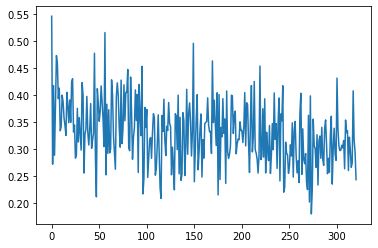

  Average training loss: 0.31
======= Epoch 4 / 6 =======
Iteration 0, loss = 0.3078, pearson_r = 0.4394, lr = 0.0000343
       - Validation output mean = 0.02761, variance = 0.07103
       - Validation MSE loss = 0.33807
       - Validation Pearson's correlation = 0.27759
Iteration 100, loss = 0.2518, pearson_r = 0.4693, lr = 0.0000240
       - Validation output mean = 0.08396, variance = 0.07772
       - Validation MSE loss = 0.33623
       - Validation Pearson's correlation = 0.28296


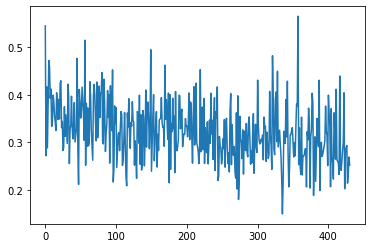

  Average training loss: 0.30
======= Epoch 5 / 6 =======
Iteration 0, loss = 0.2832, pearson_r = 0.6178, lr = 0.0000240
       - Validation output mean = 0.12547, variance = 0.06815
       - Validation MSE loss = 0.33540
       - Validation Pearson's correlation = 0.28775
Iteration 100, loss = 0.2586, pearson_r = 0.4457, lr = 0.0000168
       - Validation output mean = 0.05052, variance = 0.08147
       - Validation MSE loss = 0.33577
       - Validation Pearson's correlation = 0.28612


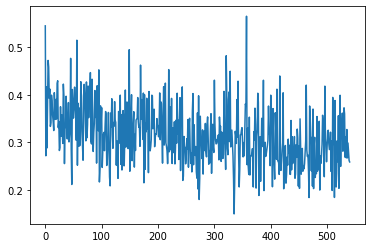

  Average training loss: 0.29
======= Epoch 6 / 6 =======
Iteration 0, loss = 0.4108, pearson_r = 0.5653, lr = 0.0000168
       - Validation output mean = 0.18160, variance = 0.07796
       - Validation MSE loss = 0.33854
       - Validation Pearson's correlation = 0.28684
Iteration 100, loss = 0.2936, pearson_r = 0.5730, lr = 0.0000118
       - Validation output mean = 0.07836, variance = 0.07770
       - Validation MSE loss = 0.33466
       - Validation Pearson's correlation = 0.28729


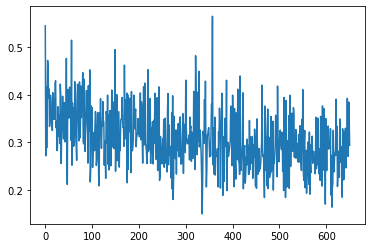

  Average training loss: 0.28


In [99]:
# instantiate model, optimizer and train
model = GatedRNNForQualityEstimation(embedding_dim, rnn_hidden_size, fc_hidden_size, dropout, tanh)

optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_fn = nn.SmoothL1Loss() # 

train(model, loader_train, loader_dev, optimizer, loss_fn, scheduler, epochs, device)

torch.cuda.empty_cache()

In [0]:
# save model
model_base_name = 'GRNN_model.pt'
model_save_path = F"/content/gdrive/My Drive/Colab Notebooks/{model_base_name}"

torch.save({'state_dict': model.state_dict(),
            'language': language,
            'max_len': max_len,
            'batch_size': batch_size,
            'seed': seed,
            'lr': lr,
            'eps': eps,
            'step_size': step_size,
            'gamma': gamma,
            'epochs': epochs,
            'rnn_hidden_size': rnn_hidden_size,
            'fc_hidden_size': fc_hidden_size,
            'dropout': dropout,
            'tanh': tanh,
            'embedding_dim': embedding_dim,
            'remove_stop_word': remove_stop_word}, model_save_path)

In [0]:
# compute scores
def get_test_output(model, loader_test):
    model.eval() # set model to evaluation mode

    scores = np.array([])

    with torch.no_grad():
        for batch in loader_test:
            x = tuple(i.to(device=device) for i in batch)
            out = model(*x)
            scores = np.concatenate([scores, out.view(-1).cpu().numpy()])
    return scores

In [0]:
import os

# write scores to file
def writeScores(scores):
    fn = "/content/gdrive/My Drive/Colab Notebooks/predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx, x in enumerate(scores):
            #out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            #print(out)
            output_file.write(f"{x}\n")

In [104]:
scores = get_test_output(model, loader_test)
writeScores(scores)

In [105]:
os.path.isfile("/content/gdrive/My Drive/Colab Notebooks/predictions.txt")

True

In [107]:
import glob

glob.glob("/content/gdrive/My Drive/Colab Notebooks/*")

['/content/gdrive/My Drive/Colab Notebooks/Untitled0.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/notebook1_pytorch_demo.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/notebook0_numpy_pytorch_intro.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/01_preprocessing_and_embeddings.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/Copy of 460cw1_2020 (1).ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/Copy of 460cw1_2020.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/02-Intro-Medical-Image-Computing.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/460cw1_2020_final (1).ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/tutorial_5.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/LabExercise5.ipynb',
 '/content/gdrive/My Drive/Colab Notebooks/dev.enzh.mt',
 '/content/gdrive/My Drive/Colab Notebooks/dev.enzh.scores',
 '/content/gdrive/My Drive/Colab Notebooks/train.enzh.scores',
 '/content/gdrive/My Drive/Colab Notebooks/dev.enzh.src',
 '/content/gdrive/My Drive/Colab 

In [0]:
from google.colab import files
from zipfile import ZipFile


with ZipFile("en-zh_svr.zip","w") as newzip:
    newzip.write("/content/gdrive/My Drive/Colab Notebooks/predictions.txt")
    newzip.write(model_save_path)
 
files.download('en-zh_svr.zip') 
